In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 13 07:10:38 2020

@author: willem van der Schans
"""


'\nCreated on Wed Apr 13 07:10:38 2020\n\n@author: willem van der Schans\n'

In [2]:

import time
import random
start_time = time.time()
random.seed(123)

import pandas as pd #Data Processing
import numpy as np # Analytics
np.random.seed(seed=123)
import matplotlib.pyplot as plt #Plots
import seaborn as sns #Plots
import warnings
from scipy import stats
from scipy.stats import norm, skew
# Set seaborn settings
color = sns.color_palette("bright")
#plt.style.use('dark_background')
#sns.set.style('darkgrid')

def ingore_warn(*args, **kwargs):
    pass
warnings.warn = ingore_warn #Ignore warnings

# Import Data

I uploaded the data to my github so the code works on any computer that runs python 3

In [3]:
test = pd.read_excel("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/SBA_test_data.xlsx")
train = pd.read_excel("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/SBA_training_data.xlsx")
codebook = pd.read_csv("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/Variables.csv")

# Codebook

In [4]:

codebook.head(codebook.shape[0])

,Variable name,Data type,Description of variable
0,LoanNr_ChkDgt,Text,Identifier – Primary key
1,Name,Text,Borrower name
2,City,Text,Borrower city
3,State,Text,Borrower state
4,Zip,Text,Borrower zip code
5,Bank,Text,Bank name
6,BankState,Text,Bank state
7,NAICS,Text,North American industry classification system ...
8,ApprovalDate,Date/Time,Date SBA commitment issued
9,ApprovalFY,Text,Fiscal year of commitment


# Exploratory Analysis and Data Cleaning

## Train

In [5]:
print(train.head(10))
print(list(train.columns))
print(format(train.shape))

   LoanNr_ChkDgt                            Name            City State    Zip  \
0     1000014003                  ABC HOBBYCRAFT      EVANSVILLE    IN  47711   
1     1000024006     LANDMARK BAR & GRILLE (THE)       NEW PARIS    IN  46526   
2     1000034009           WHITLOCK DDS, TODD M.     BLOOMINGTON    IN  47401   
3     1000044001   BIG BUCKS PAWN & JEWELRY, LLC    BROKEN ARROW    OK  74012   
4     1000054004     ANASTASIA CONFECTIONS, INC.         ORLANDO    FL  32801   
5     1000084002  B&T SCREW MACHINE COMPANY, INC      PLAINVILLE    CT   6062   
6     1000093009   MIDDLE ATLANTIC SPORTS CO INC           UNION    NJ   7083   
7     1000094005                 WEAVER PRODUCTS     SUMMERFIELD    FL  34491   
8     1000104006                TURTLE BEACH INN  PORT SAINT JOE    FL  32456   
9     1000124001         INTEXT BUILDING SYS LLC     GLASTONBURY    CT   6073   

                            Bank BankState   NAICS ApprovalDate  ApprovalFY  \
0               FIFTH THIRD B

In [6]:
print(train['MIS_Status'].value_counts())

P I F     8118
CHGOFF    1861
Name: MIS_Status, dtype: int64


### Missing Values

                  Sum of Missing
ChgOffDate                  8053
MIS_Status                    21
DisbursementDate              16
Bank                           6
BankState                      6
Name                           4
RevLineCr                      1


Text(0.5, 0, 'Features')

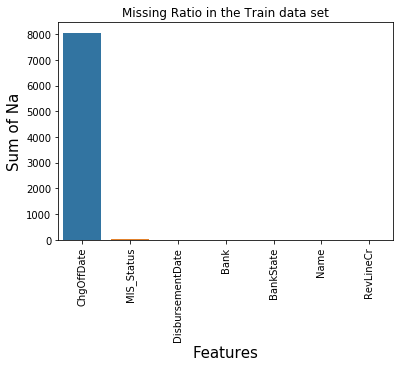

In [7]:
# Missing Values
trainnull = train.isnull().sum()
trainnulldf = trainnull.to_frame().T
trainnulldf = trainnulldf.transpose()
trainnulldf.columns = ['Sum of Missing']
trainnulldf = trainnulldf.drop(trainnulldf[(trainnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(trainnulldf)    


sns.barplot(x=trainnulldf.index, y=trainnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

After carefull consideration and exploration of the train data set these are the sets that will be taken to clean the data. All changes made are according to the codebook, If the data does not reflect the codebook entries or description it is deemed an error and therefore has to be cleaned.
 
1. Remove LoanNr_ChkDgt and Name: as they are idenifier variables they can be removed since an algorithm will not be able to extract usefull conntection from variables like this.
 
2. NAICS will also be removed due to the large amount of 0's which will cause the alogirthm to pool these entries together when they should not be. 
 
3. RevLineCr will be imputed like this: if row[RevlineCr] != Y then impute N. Aka a mode imputation. This variable will be checked for noise in the final scores and be evaluated for removal.
 
4. LowDOC will also get a mode impitation the C will become a N. 
 
5. CHgOffDate will be changed to a boolean with 0= NA and 1= Any date, this since it can be assumed that if there is no date then there has never been default.

6. DisimbursementDate, Bank, Bankstate all have a low amount of NA's the rows in which these NA's occur will be removed. This leaves the train data with a large enough sample size for algorithms to work properly, it will however reduce noise. 
 
7. BalanceGross will be removed as this variable only contains 0's and nothing else therefore being effectively uselss for any predictive analytics. 
 
8. MIS_stats will also have it's rows removed in which na's occur like number 6.
 
9. Remove City and ZIP

10. Franchise to Binary 0 for no franchise 1 for franchise 

### Na imputation

In [8]:
#Number 3  
print(train['RevLineCr'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('RevLineCr')] != "Y":
        train.at[i, 'RevLineCr'] = "N"
    else:
        train.at[i, 'RevLineCr'] = "Y"
        
print(train['RevLineCr'].value_counts())

N    4344
Y    3546
0    1688
T     419
,       1
`       1
Name: RevLineCr, dtype: int64
N    6454
Y    3546
Name: RevLineCr, dtype: int64


In [9]:
#Number 4  
print(train['LowDoc'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('LowDoc')] != "Y":
        train.at[i, 'LowDoc'] = "N"
    else:
        train.at[i, 'LowDoc'] = "Y"
        
print(train['LowDoc'].value_counts())

N    9046
Y     953
C       1
Name: LowDoc, dtype: int64
N    9047
Y     953
Name: LowDoc, dtype: int64


In [10]:
#Number 5
train['ChgOffDate'] = train['ChgOffDate'].fillna(0)

for i in train.index:
    if train.iloc[i,train.columns.get_loc('ChgOffDate')] != 0:
        train.at[i, 'ChgOffDate'] = 1
    else:
        train.at[i, 'ChgOffDate'] = 0
        
print(train['ChgOffDate'].value_counts())

0    8053
1    1947
Name: ChgOffDate, dtype: int64


In [11]:
#Number 10 
print(train['FranchiseCode'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('FranchiseCode')] > 1:
        train.at[i, 'FranchiseCode'] = 1
    else:
        train.at[i, 'FranchiseCode'] = 0
        
print(train['FranchiseCode'].value_counts())

1        9434
0         125
78760      23
50564      16
68020      14
         ... 
8047        1
8015        1
9800        1
30210       1
75985       1
Name: FranchiseCode, Length: 250, dtype: int64
0    9559
1     441
Name: FranchiseCode, dtype: int64


In [12]:
# Number 1
train.drop(columns=['LoanNr_ChkDgt', 'Name'], inplace=True)

# Number 2
train.dropna(subset=['NAICS'], inplace=True)

# Number 6
train.dropna(subset=['Bank'], inplace=True)
train.dropna(subset=['BankState'], inplace=True)
train.dropna(subset=['DisbursementDate'], inplace=True)

# Number 7
train.drop(columns=['BalanceGross'], inplace=True)

# Number 8
train.dropna(subset=['MIS_Status'], inplace=True)

#Number 9
train.drop(columns=['City'], inplace=True)
train.drop(columns=['Zip'], inplace=True)

#Remove Specific Dates?
train.drop(columns=['ApprovalDate'], inplace=True)
train.drop(columns=['DisbursementDate'], inplace=True)
train.drop(columns=['NAICS'], inplace=True)

In [13]:
# Missing Values
trainnull = train.isnull().sum()
trainnulldf = trainnull.to_frame().T
trainnulldf = trainnulldf.transpose()
trainnulldf.columns = ['Sum of Missing']
trainnulldf = trainnulldf.drop(trainnulldf[(trainnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(trainnulldf) 

Empty DataFrame
Columns: [Sum of Missing]
Index: []


## Test

In [14]:
print(test.head(10))
print(list(test.columns))
print(format(test.shape))

   LoanNr_ChkDgt                            Name           City State    Zip  \
0     1069795008                 Maple Dye, Inc.    LOS ANGELES    CA  90005   
1     1069835007       Resource Solutions, Corp.       COLUMBUS    WI  53925   
2     1069855002                Shadow Horse LLC  BRADLEY BEACH    NJ   7720   
3     1069865005  Cold Mountain Company dba Robe        HOUSTON    TX  77098   
4     1069875008  Double K Equipment Sales, Inc.         Minden    LA  71055   
5     1069884004     TUMBLEWEED GYMNASTICS, INC.     FORT WORTH    TX  76112   
6     1069885000        M.D. Science Lab, L.L.C.  POMPANO BEACH    FL  33060   
7     1069895003           Butthead Covers, Inc.        GILBERT    AZ  85296   
8     1069905004   Sunrise Interior Specialists,        PHOENIX    AZ  85009   
9     1069914000                    I AM STAMPIN          UNITY    WI  54488   

                             Bank BankState   NAICS ApprovalDate  ApprovalFY  \
0      BANK OF AMERICA NATL ASSOC      

### Missing Values

                  Sum of Missing
ChgOffDate                  1000
MIS_Status                  1000
ChgOffPrinGr                1000
DisbursementDate               2
Bank                           1
BankState                      1
RevLineCr                      1


Text(0.5, 0, 'Features')

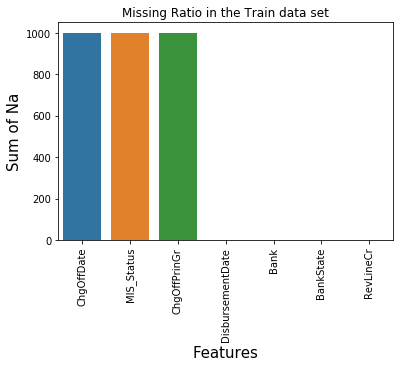

In [15]:
testnull = test.isnull().sum()
testnulldf = testnull.to_frame().T
testnulldf = testnulldf.transpose()
testnulldf.columns = ['Sum of Missing']
testnulldf = testnulldf.drop(testnulldf[(testnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(testnulldf)    

#plt.subplots(figsize=(12,9))
sns.barplot(x=testnulldf.index, y=testnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

Here I will do the same imputation and transformation I have done for the train data set with the exception of the target variables. 

In [16]:
#Number 3  
print(test['RevLineCr'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('RevLineCr')] != "Y":
        test.at[i, 'RevLineCr'] = "N"
    else:
        test.at[i, 'RevLineCr'] = "Y"
        
print(test['RevLineCr'].value_counts())

N    494
Y    399
0     67
T     39
Name: RevLineCr, dtype: int64
N    601
Y    399
Name: RevLineCr, dtype: int64


In [17]:
#Number 4  
print(test['LowDoc'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('LowDoc')] != "Y":
        test.at[i, 'LowDoc'] = "N"
    else:
        test.at[i, 'LowDoc'] = "Y"
        
print(test['LowDoc'].value_counts())

N    921
Y     79
Name: LowDoc, dtype: int64
N    921
Y     79
Name: LowDoc, dtype: int64


In [18]:
#Number 10 
print(test['FranchiseCode'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('FranchiseCode')] > 1:
        test.at[i, 'FranchiseCode'] = 1
    else:
        test.at[i, 'FranchiseCode'] = 0
        
print(test['FranchiseCode'].value_counts())

1        949
0         18
78760      4
72590      2
49952      2
24850      2
50564      1
53250      1
33170      1
84025      1
64650      1
67750      1
60590      1
21780      1
79140      1
73000      1
73675      1
53650      1
64975      1
46561      1
52707      1
1560       1
5725       1
50860      1
17100      1
46875      1
73525      1
52000      1
45505      1
Name: FranchiseCode, dtype: int64
0    967
1     33
Name: FranchiseCode, dtype: int64


In [19]:
# Number 1
test.drop(columns=['LoanNr_ChkDgt', 'Name'], inplace=True)

# Number 2
test.dropna(subset=['NAICS'], inplace=True)

# Number 6
test.dropna(subset=['Bank'], inplace=True)
test.dropna(subset=['BankState'], inplace=True)
test.dropna(subset=['DisbursementDate'], inplace=True)

# Number 7
test.drop(columns=['BalanceGross'], inplace=True)

#Number 9
test.drop(columns=['City'], inplace=True)
test.drop(columns=['Zip'], inplace=True)

#Remove Specific Dates?
test.drop(columns=['ApprovalDate'], inplace=True)
test.drop(columns=['DisbursementDate'], inplace=True)
test.drop(columns=['NAICS'], inplace=True)


              Sum of Missing
ChgOffDate               998
MIS_Status               998
ChgOffPrinGr             998


Text(0.5, 0, 'Features')

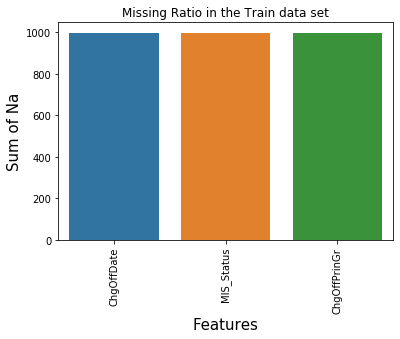

In [20]:
# Missing Values
testnull = test.isnull().sum()
testnulldf = testnull.to_frame().T
testnulldf = testnulldf.transpose()
testnulldf.columns = ['Sum of Missing']
testnulldf = testnulldf.drop(testnulldf[(testnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(testnulldf)    

sns.barplot(x=testnulldf.index, y=testnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

## Comparison of Data Sets after Cleaning

here I compare columns to make sure that the data sets are identical in its variables, if they are not algorithms will throw errors or warnings.

In [21]:
traincol = list(train.columns)
testcol = list(test.columns)

def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

print("Column difference:",Diff(traincol,testcol))

print("Train Dimensions:", format(train.shape))
print("Test Dimensions:", format(test.shape))

Column difference: []
Train Dimensions: (9965, 19)
Test Dimensions: (998, 19)


As we can see there are some entries lost however this method is more robust then any reasonable form of imputation especially regarding the missing bank entries. Guessing what bank was the bank that issues these loans is risky and not statstically robust. The sample size of what is left is sufficient to perform predictive analysis without overfitting. 

## Merge Data Sets

Data sets will be merged for easier label and one-hot encoding, together with skewness analysis. I do this now since when the NA's were imputed a number of rows were removed which would change the shape of the data sets making it hard to find out where to cut them apart later.

In [22]:
# Save Rowcount of Data set to seperate later
ntrain = train.shape[0]
ntest = test.shape[0]

#Save Target Variables
y_ChgOffDate = train.ChgOffDate.values


y_MIS_Status = train.MIS_Status.values


y_ChgOffPrinGr = train.ChgOffPrinGr.values


# Merge Data sets.
alldata = pd.concat((train, test)).reset_index(drop=True)
alldata.drop(['ChgOffDate', 'MIS_Status', 'ChgOffPrinGr'], axis=1, inplace=True)
print(format(alldata.shape))


(10963, 16)


## WebScraping

For webscraping I downloaded a data set of the internet of past recession periods in the US. I then created a dictionary out the years and included them in a new column based on ApprovedFY. This column is a binominal variable called recession. For conservation purposes I also uploaded this data to my GITHUB and added a row to be able to call this data, however this is currently not utilized.

The Data Comes from the St. Louid Federal Reserve Bank more about them here: https://research.stlouisfed.org/about.html

In [23]:
recession = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=JHDUSRGDPBR&scale=left&cosd=1967-10-01&coed=2019-07-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2020-04-15&revision_date=2020-04-15&nd=1967-10-01")
#recession = pd.read_csv("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/JHDUSRGDPBR.csv")

recession.rename(columns = {"JHDUSRGDPBR" : "Recession", "DATE" : "Date"}, inplace=True)

recession['Date'] = pd.to_datetime(recession['Date'])
recession['Recession'] = recession['Recession'].astype('int64').astype(dtype="category")

recession['Year'] = recession['Date'].dt.year


In [24]:
recession = recession.reset_index()
recession = recession.pivot(index='index', columns='Year', values='Recession')
recession = recession.mode(axis = 0, dropna=True)
recession = recession.drop(index=recession.index.difference([0]))

keys = tuple(recession.columns)
values = tuple(recession.to_numpy()[0])

rename_dict = dict(zip(keys, values))

In [25]:
alldata['Recession'] = alldata['ApprovalFY']
alldata['Recession'] = alldata['Recession'].replace(rename_dict)
alldata['Recession'].fillna(0, inplace=True)

print(alldata['Recession'].value_counts())

0    10830
1      133
Name: Recession, dtype: int64


## Further Cleaning of AllData

In [26]:
y_MIS_Status = pd.DataFrame(y_MIS_Status)

#Number 4  
print(y_MIS_Status[0].value_counts())

for i in y_MIS_Status.index:
    if y_MIS_Status.iloc[i,y_MIS_Status.columns.get_loc(0)] != "P I F":
        y_MIS_Status.at[i, 0] = 1
    else:
        y_MIS_Status.at[i, 0] = 0
        
print(y_MIS_Status[0].value_counts())

y_MIS_Status = y_MIS_Status.to_numpy()

P I F     8108
CHGOFF    1857
Name: 0, dtype: int64
0    8108
1    1857
Name: 0, dtype: int64


In [27]:
# Give Correct Data Label to target variables
y_ChgOffDate=y_ChgOffDate.astype('int')
y_MIS_Status = y_MIS_Status.astype('int')
y_ChgOffPrinGr = y_ChgOffPrinGr.astype('int')

# Feature Engineering

## Target Variable

For the target variable I will use CHGOffDate with classification algortihms. I chose this variable because when cleaning the data set I changed more about MIS_Status then I did to ChgOffDate therefore making ChgOffDate a more relibable predictor. Also after trying over and over again to improve regression scores on ChgOffPrinGr I ended up with an error of around 50k. I ran into the variable having a zero-inflated probability distribution which I don't know how to deal with as if now. I therefore chose to remove this variable as a target and focus on classification. 

[8028, 1937]


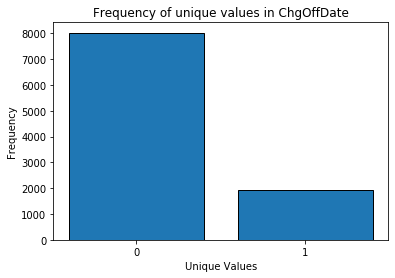

In [28]:
import collections

c = list(y_ChgOffDate)
name = str(c).split()

c = collections.Counter(c)
c = sorted(c.items())
y_ChgOffDate_num = [i[0] for i in c]
y_ChgOffDate_names = [name[i[0]-1] for i in c]
freq = [i[1] for i in c]

print(freq)

f, ax = plt.subplots()

plt.bar(y_ChgOffDate_num, freq, edgecolor='black')
plt.title("Frequency of unique values in ChgOffDate")
plt.xlabel("Unique Values")
plt.ylabel("Frequency")
ax.set_xticks(range(0, 2))
ax.set_xticklabels(range(0,2))

plt.show()


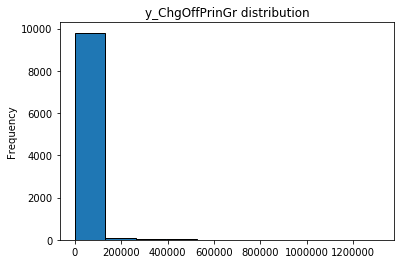

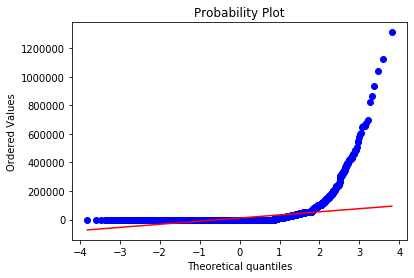

In [29]:
# Plot the distribution of the target variable
plt.hist(y_ChgOffPrinGr, edgecolor='black')
plt.ylabel('Frequency') # Add the Title
plt.title('y_ChgOffPrinGr distribution')
plt.show()

# Plot the QQ-plot of the target variable

fig = plt.figure()
res = stats.probplot(y_ChgOffPrinGr, plot=plt)
plt.show()

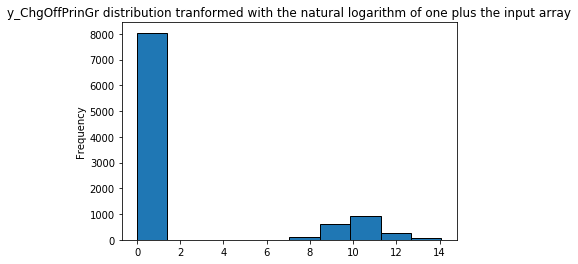

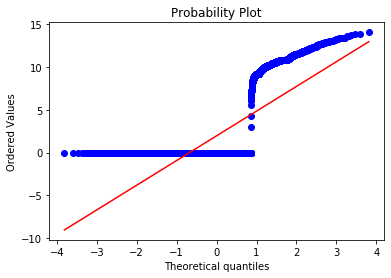

In [30]:
# Plot the distribution of the target variable
plt.hist(np.log1p(y_ChgOffPrinGr), edgecolor='black')
plt.ylabel('Frequency') # Add the Title
plt.title('y_ChgOffPrinGr distribution tranformed with the natural logarithm of one plus the input array')

# Plot the QQ-plot of the target variable

fig = plt.figure()
res = stats.probplot(np.log1p(y_ChgOffPrinGr), plot=plt)
plt.show()

## Correlation Matrix

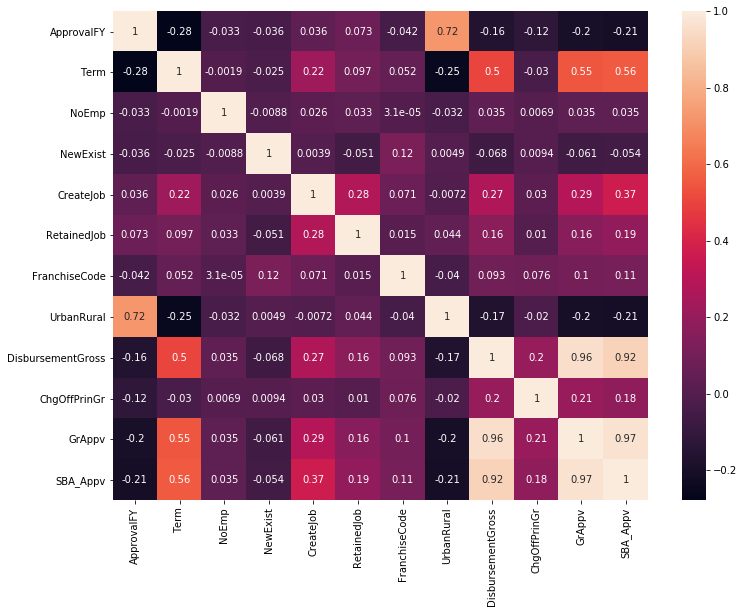

In [31]:
correlation = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True)

## Label Encoding

Bank is label encoded since one-hot encoding it will create a data set that is so big it hinders performance to an extreme degree. 

In [32]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder() 
lbl.fit(list(alldata['Bank'].values)) 
alldata['Bank'] = lbl.transform(list(alldata['Bank'].values))

# shape        
print(format(alldata.shape))

(10963, 17)


## Skewness and Box-Cox Transformations

In [33]:
numeric_feats = alldata.dtypes[alldata.dtypes == "int64"].index

# Check the skew of all numerical features
skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(21)


Skew in numerical features: 



,Skew
NoEmp,70.872035
RetainedJob,16.636037
CreateJob,14.703799
Recession,8.912960
SBA_Appv,5.031105
DisbursementGross,4.699813
GrAppv,4.611168
FranchiseCode,4.496963
Term,1.786472
NewExist,0.723012


In [34]:
skewness = skewness[abs(skewness) > .75]
skewness.dropna(inplace=True)

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15 #Regularly Picked Value
for feat in skewed_features:
    alldata[feat] = boxcox1p(alldata[feat], lam)
    
numeric_feats = alldata.dtypes[alldata.dtypes == "int64"].index

# Check the skew of all numerical features
skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(21)


Skew in numerical features: 



,Skew
NewExist,0.723012
Bank,0.417791
UrbanRural,0.261263


## One-hot Encoding

In [35]:
print("Variables that will be one-hot encoded are:", list(alldata.dtypes[alldata.dtypes == "object"].index))
print(alldata.shape)

Variables that will be one-hot encoded are: ['State', 'BankState', 'RevLineCr', 'LowDoc']
(10963, 17)


In [36]:
alldata = pd.get_dummies(alldata)
print(alldata.shape)

(10963, 120)


## Recreate Train and Test Data Sets

In [37]:
train = alldata[:ntrain]
test = alldata[ntrain:]

## Data Scaling

I looked into data scaling to help with an ill-condition matrix warning thrown by the KRR algorithm. While I normally would scale my data, this would make it extremely hard to do point 8 effectively. Additionally I am not using any Kernel tricks anymore so this is less of a problem now.

In [38]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(train)

#train = scaler.transform(train)
#test = scaler.transform(test)

#train = pd.DataFrame(train)
#test = pd.DataFrame(test)

## Hold-Out evaluation 

I do this since the correct answers aren't available and I want to make sure my algorithms perform. By utilizing crossvalidation and Hold-Out evaluation I can be confident about my results. This also allows me to easily see my insample accuracy which means I can combat overfitting more easily.

In [39]:
from sklearn.model_selection import train_test_split

HO_X_train1, HO_X_test1, HO_y_train_CL, HO_y_test_CL = train_test_split(train, y_ChgOffDate, test_size=0.15)

HO_X_train2, HO_X_test2, HO_y_train_CO, HO_y_test_CO = train_test_split(train, y_ChgOffPrinGr, test_size=0.15)

## Cross-Validation

The Main metric I will use to evaulate my alogrithms is the accuracy measure.

In [40]:
#Validation function
n_folds = 5

def acc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    acc= cross_val_score(model, train.values, y_train, scoring='accuracy', cv = kf)
    return(acc)

# Machine Learning

## Load Algorithms

In [41]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

# XGBoost
import xgboost as xgb

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Support Vector Classification.
from sklearn.svm import SVC

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

#Create Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score

## Set Options

#### Support Vector Classification
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

#### K Neighbors Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### XGBoost
https://xgboost.readthedocs.io/en/latest/parameter.html

In [42]:
model_SVC = SVC(cache_size = 8000)

model_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm = 'auto', n_jobs = -1)

model_RFC = RandomForestClassifier(n_jobs = -1)


model_xgb = xgb.XGBClassifier(colsample_bytree=0.5, gamma=0.5, 
                             learning_rate=0.1, max_depth=6, 
                             min_child_weight=1.5, n_estimators=2200,
                             reg_alpha=0.25, reg_lambda=0.5,
                             subsample=0.5, silent=1,
                             random_state =7, nthread = -1)

y_train = y_ChgOffDate #Target Variable

## Find Accuracy Scores by using Cross-Validation

In [43]:
score_RFC = acc_cv(model_RFC)
print("Random Forest Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_RFC.mean(), score_RFC.std()))

model_RFC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

RFC_train_pred = model_RFC.predict(HO_X_train1) #InSample Holdout RMSE

RFC_pred_HO = model_RFC.predict(HO_X_test1) #Out of Sample Holdout RMSE
print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, RFC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("In-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_train_CL, RFC_train_pred, normalize=True, sample_weight=None))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, RFC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_test_CL, RFC_pred_HO, normalize=True, sample_weight=None))

Random Forest Cross-Val Accuracy score: 0.9390 (0.0249)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6822     0  6822
1             0  1648  1648
All        6822  1648  8470
In-Sample Hold-Out Accuracy =  1.0


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1190   16  1206
1            72  217   289
All        1262  233  1495
Out-Of-Sample Hold-Out Accuracy =  0.9411371237458194


In [44]:
#####Cross-Validation#####
score_SVC = acc_cv(model_SVC)
print("SVC Accuracy score: {:.4f} ({:.4f})\n".format(score_SVC.mean(), score_SVC.std()))

#####Hold-Out#####
model_SVC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

SVC_train_pred = model_SVC.predict(HO_X_train1) #InSample Holdout RMSE

SVC_pred_HO = model_SVC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, SVC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_train_CL, SVC_train_pred, normalize=True, sample_weight=None))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, SVC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_test_CL, SVC_pred_HO, normalize=True, sample_weight=None))

SVC Accuracy score: 0.8056 (0.0002)



########In-Sample Hold-Out########
Predicted     0   All
Actual               
0          6822  6822
1          1648  1648
All        8470  8470
Out-Of-Sample Hold-Out Accuracy =  0.80543093270366


########Out-Of-Sample Hold-Out########
Predicted     0   All
Actual               
0          1206  1206
1           289   289
All        1495  1495
Out-Of-Sample Hold-Out Accuracy =  0.8066889632107024


In [45]:
score_KNN = acc_cv(model_KNN)
print("KNN Accuracy score: {:.4f} ({:.4f})\n".format(score_KNN.mean(), score_KNN.std()))

model_KNN.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

KNN_train_pred = model_KNN.predict(HO_X_train1) #InSample Holdout RMSE

KNN_pred_HO = model_KNN.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, KNN_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_train_CL, KNN_train_pred, normalize=True, sample_weight=None))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, KNN_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_test_CL, KNN_pred_HO, normalize=True, sample_weight=None))

KNN Accuracy score: 0.8806 (0.0266)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6822     0  6822
1             0  1648  1648
All        6822  1648  8470
Out-Of-Sample Hold-Out Accuracy =  1.0


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1170   36  1206
1           123  166   289
All        1293  202  1495
Out-Of-Sample Hold-Out Accuracy =  0.8936454849498328


In [46]:
score_xgb = acc_cv(model_xgb)
print("Xgboost Accuracy score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

xgb_train_pred = model_xgb.predict(HO_X_train1) #InSample Holdout RMSE

xgb_pred_HO = model_xgb.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, xgb_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_train_CL, xgb_train_pred, normalize=True, sample_weight=None))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, xgb_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Out-Of-Sample Hold-Out Accuracy = ",accuracy_score(HO_y_test_CL, xgb_pred_HO, normalize=True, sample_weight=None))

Xgboost Accuracy score: 0.9497 (0.0164)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6819     3  6822
1             8  1640  1648
All        6827  1643  8470
Out-Of-Sample Hold-Out Accuracy =  0.9987012987012988


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1184   22  1206
1            50  239   289
All        1234  261  1495
Out-Of-Sample Hold-Out Accuracy =  0.9518394648829431


## Evaluation of Scores

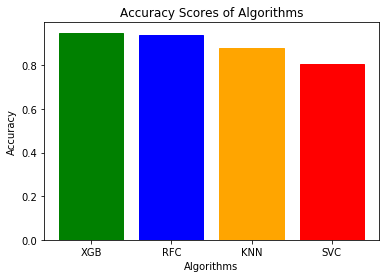

,Score
XGB,0.949724
RFC,0.938986
KNN,0.880582
SVC,0.805620


In [47]:
scores = {'RFC' : score_RFC.mean(),
                   'SVC': score_SVC.mean(), 
                   'KNN' : score_KNN.mean(), 
                   'XGB' : score_xgb.mean()}
scores_sorted = {k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])}

scores_sorted
keys = scores_sorted.keys()
values = scores_sorted.values()



barplot = plt.bar(keys, values)
barplot[0].set_color('g')
barplot[1].set_color('b')
barplot[2].set_color('orange')
barplot[3].set_color('red')
plt.title("Accuracy Scores of Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")

plt.show()


scores = pd.DataFrame.from_dict(scores, orient='index',columns=['Score'])

scores.sort_values(by = 'Score', ascending=False)

There are two models who are predicting with high accuracy namely: XGBoost and Random Forest. I will use both these in the Loan officer app of step 9. I will also print both of the generaterd predicted values to a CSV since both of these algorithms seem to be quite accuracte. 

## Exporting Predictions

In [48]:
model_xgb.fit(train, y_train) #Train on Full Train Data
xgb_pred = model_xgb.predict(test) #Predict on Test
xgb_pred = pd.DataFrame(xgb_pred)
xgb_pred.to_csv('xgb_classifier_pred.csv',index=False)

In [49]:
model_RFC.fit(train, y_train) #Train on Full Train Data
RFC_pred = model_RFC.predict(test) #Predict on Test
RFC_pred = pd.DataFrame(RFC_pred)
RFC_pred.to_csv("RFC_classifier_pred.csv",index=False)

##### Stop Code Timing

In [50]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 123.21951627731323 seconds ---
